# Baselines and Gaussian Processes

In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import math
import warnings
import joblib

from sklearn.datasets import make_friedman2
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic, ExpSineSquared, ConstantKernel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from scipy.stats import norm
import GPy

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping

from matplotlib.ticker import FuncFormatter

from utils import *

2024-04-20 16:21:41.890338: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-20 16:21:41.891757: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-20 16:21:41.909366: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-20 16:21:41.909383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-20 16:21:41.909905: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

##### Flags

In [3]:
# Set to true if you run on Google Colab
COLAB = False

# Set TRAIN to True if want to retrain the models
TRAIN = True

# Set confidence interval to be considered as 'normal behaviour'
CONFIDENCE_INTERVAL = 0.99

GPU = True
if GPU:
    tf.config.set_visible_devices([], 'GPU')
    print("Using GPU")

Using GPU


2024-04-20 16:21:43.878906: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-20 16:21:43.879129: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


##### Data Set

In [4]:
# In order to ensure that each model has repeatable results,we fix the seed both for the
# data splitting part and for the initilialization of the networks' weights. Theoretially
# speaking, we should average over different seeds to ensure the robustness of our results.
# However, in practice, due to the size of the data set this is unfeasibile and we only do
# this for the best performing model to show that the variability of results based on seed
# is almost none.

keras.utils.set_random_seed(812)
MODELS_SEED = 42

In [6]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = "/content/drive/My Drive/Colab Notebooks/FYP/UK Wind Turbines"

df_train = pd.read_pickle(open(DATA_PATH + '/cleaned/train.pkl','rb'))
df_test = pd.read_pickle(open(DATA_PATH + '/cleaned/test.pkl','rb'))

In [7]:
print("Full Training Set Size: ", df_train.shape[0])
print("Full Testing Set Size: ", df_test.shape[0])

df_train_single = df_train[df_train['turbine'] == TURBINE_ID]
df_test_single = df_test[df_test['turbine'] == TURBINE_ID]
df_train_single.reset_index(drop=True, inplace=True)
print("Turbine#{TURBINE_ID} Training Set Size: ", df_train.shape[0])
print("Turbine#{TURBINE_ID} Testing Set Size: ", df_test.shape[0])
df = pd.concat([df_train_single, df_test_single])

Full Training Set Size:  807764
Full Testing Set Size:  201943
Turbine#{TURBINE_ID} Training Set Size:  807764
Turbine#{TURBINE_ID} Testing Set Size:  201943


In [8]:
descriptive_stats = df[FEATURES + [OUTPUT_FEATURE]].describe()
pd.set_option('display.max_columns', None)
display(descriptive_stats)

,Wind.speed.me,Wind.speed.sd,Wind.speed.min,Wind.speed.max,Front.bearing.temp.me,Front.bearing.temp.sd,Front.bearing.temp.min,Front.bearing.temp.max,Rear.bearing.temp.me,Rear.bearing.temp.sd,Rear.bearing.temp.min,Rear.bearing.temp.max,Rotor.bearing.temp.me,Stator1.temp.me,Nacelle.ambient.temp.me,Nacelle.temp.me,Transformer.temp.me,Gear.oil.temp.me,Gear.oil.inlet.temp.me,Top.box.temp.me,Hub.temp.me,Conv.Amb.temp.me,Transformer.cell.temp.me,Motor.axis1.temp.me,Motor.axis2.temp.me,CPU.temp.me,Blade.ang.pitch.pos.A.me,Blade.ang.pitch.pos.B.me,Blade.ang.pitch.pos.C.me,Gear.oil.inlet.press.me,Gear.oil.pump.press.me,Drive.train.acceleration.me,Tower.Acceleration.x,Tower.Acceleration.y,Power.me
count,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000
mean,6.061792,0.929598,4.285672,7.826800,65.249559,0.611390,64.235198,66.234087,63.228148,0.665511,62.131779,64.294001,25.147016,62.680004,10.395775,19.545742,48.827492,52.035799,48.283892,24.561808,20.016075,14.146877,16.435012,42.007367,42.461620,53.257354,4.664098,4.664053,4.664393,118.197068,459.291346,21.301466,57.177760,27.941015,624.587598
std,2.767883,0.461186,2.206099,3.482993,10.096854,0.504141,9.916454,10.287366,8.592414,0.576825,8.409253,8.819052,3.963058,7.853748,5.895684,5.386682,19.850288,5.862262,8.085823,3.431033,4.873869,6.028698,5.922955,18.629214,18.868266,3.212041,12.673886,12.673785,12.674054,54.677459,164.758023,36.644667,30.554552,15.813479,631.196896
min,0.129863,0.000000,-0.444250,0.243750,14.565001,0.000000,14.400000,14.600000,13.147500,0.000000,13.100000,13.200000,9.002500,13.720000,-6.800000,1.245000,18.690001,13.857500,9.235000,9.520000,7.762000,-2.642500,-1.037500,10.400000,11.000000,38.000000,0.000000,0.000000,0.000000,-4.160219,5.963073,3.013230,1.225289,2.458500,-21.170280
25%,4.052706,0.595049,2.674919,5.362026,61.002500,0.236114,60.099998,61.900002,61.092499,0.240885,60.400002,61.849998,22.215000,59.665001,6.020000,15.917500,35.562500,49.326313,42.110000,22.900000,16.043158,9.677500,11.925000,27.074500,28.000000,52.000000,0.000000,0.000000,0.000000,83.152820,352.544764,4.978957,36.144118,17.303601,122.224066
50%,5.707567,0.851638,4.071932,7.317771,69.794736,0.475730,68.449997,70.900002,66.140001,0.477723,65.050003,67.000000,25.049999,62.027500,9.690000,19.530000,42.087499,53.122500,50.200000,24.920000,19.000000,13.590000,16.092500,36.849998,37.124000,53.525002,0.026500,0.026500,0.026500,98.062714,404.299846,7.397583,54.777193,25.706060,382.674857
75%,7.657582,1.180467,5.618109,9.794380,72.277500,0.845470,71.199997,73.300003,68.575001,0.928453,67.199997,70.000000,28.059524,64.492499,14.352500,23.075000,54.002631,56.322498,55.132500,26.395000,23.196500,18.242500,20.514999,54.286500,54.245499,55.000000,1.116000,1.116000,1.117000,151.218739,564.198951,14.488859,77.716939,35.893112,967.920566
max,22.151195,5.016237,17.995665,32.264656,81.182500,7.816919,80.800003,81.449997,75.092500,7.473754,74.649994,76.400002,39.097499,103.014999,35.225000,39.430000,107.987503,59.926316,60.208335,39.863889,38.359000,43.762500,42.076316,85.001000,87.000000,68.900000,89.989998,89.989998,90.000000,305.390411,1169.453369,327.393707,272.232208,192.845093,2084.067871


In [9]:
X_train, X_test, \
    y_train, y_test, \
    scaler = create_design_matrix(df_train_single, df_test_single, FEATURES, OUTPUT_FEATURE)

X_train_wind, X_test_wind, \
    _, _, \
    scaler_wind = create_design_matrix(df_train_single, df_test_single, ['Wind.speed.me'], OUTPUT_FEATURE)

In [10]:
print(X_train.shape, X_train_wind.shape)

(151504, 34) (151504, 1)


## Baseline Models

Below are presented two baseline, low computational cost, baseline models. We present a linear regression and a decision tree regression with 5-fold cross-validation. While these model are incapable of quiantifying the uncertainty in their predictions, a property that we require for our probabilistic approach in condition monitoring for a wind turbine's power curve, they provide a prediction error baseline which we can use to evaluate our different Gaussian Processes models. 

### Linear Regression

#### Ordinary Least Square (OLS)

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [13]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

evaluate_and_save_metrics("OLS Regresion", y_train, y_test, y_train_pred, y_test_pred, ci=CONFIDENCE_INTERVAL)

Train RMSE: 98.527
Test RMSE: 99.201
Train MAE: 68.000
Test MAE: 68.498
Percentage of Test Data Points within 99.00% CI: -%
Percentage of Test Data Points within 99.00% CI: -%
Percentage of Test Data Points within 99.00% CI: -%
Percentage of Test Data Points within 99.00% CI: -%


#### Ridge Regression

In [9]:
lr_ridge = Ridge()
lr_ridge.fit(X_train, y_train)

Ridge()

In [10]:
y_train_pred = lr_ridge.predict(X_train)
y_test_pred = lr_ridge.predict(X_test)

evaluate_and_save_metrics("Ridge Regresion", y_train, y_test, y_train_pred, y_test_pred, ci=CONFIDENCE_INTERVAL)

Train RMSE: 98.530
Test RMSE: 99.201
Train MAE: 68.005
Test MAE: 68.501
Percentage of Test Data Points within 99.00% CI: -%
Percentage of Test Data Points within 99.00% CI: -%
Percentage of Test Data Points within 99.00% CI: -%
Percentage of Test Data Points within 99.00% CI: -%


### Decision Tree with 5-fold CV

In [14]:
# Hyperparameters to search over
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_leaf': [1, 5, 10],
}

decision_tree_model = DecisionTreeRegressor(random_state=42, min_samples_split=10)

grid_search = GridSearchCV(decision_tree_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
decision_tree_model = grid_search.best_estimator_
joblib.dump(decision_tree_model, "./saved_models/decision_tree.joblib")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .................max_depth=None, min_samples_leaf=1; total time=   3.6s
[CV] END .................max_depth=None, min_samples_leaf=1; total time=   3.6s
[CV] END .................max_depth=None, min_samples_leaf=1; total time=   3.6s
[CV] END .................max_depth=None, min_samples_leaf=1; total time=   3.6s
[CV] END .................max_depth=None, min_samples_leaf=1; total time=   3.6s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   3.4s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   3.4s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   3.3s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   3.4s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   3.4s
[CV] END ................max_depth=None, min_samples_leaf=10; total time=   3.1s
[CV] END ................max_depth=None, min_sam

['./saved_models/decision_tree.joblib']

In [24]:
best_params = grid_search.best_params_
print("Optimal hyperparameters: ", best_params)

Optimal hyperparameters:  {'max_depth': 15, 'min_samples_leaf': 10}


In [25]:
y_train_pred = decision_tree_model.predict(X_train)
y_test_pred = decision_tree_model.predict(X_test)

evaluate_and_save_metrics("Decision Tree (CV)", y_train, y_test, y_train_pred, y_test_pred, ci=CONFIDENCE_INTERVAL)

Train RMSE: 29.954
Test RMSE: 44.661
Train MAE: 18.211
Test MAE: 26.856
Percentage of Test Data Points within 99.00% CI: -%
Percentage of Test Data Points within 99.00% CI: -%


### Random Forest with 5-fold CV

In [26]:
grid_search = GridSearchCV(RandomForestRegressor(random_state=42, n_estimators=20), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Optimal hyperparameters: ", best_params)
random_forest_model = grid_search.best_estimator_
joblib.dump(random_forest_model, "./saved_models/random_forest.pkl")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .................max_depth=None, min_samples_leaf=1; total time=  52.3s
[CV] END .................max_depth=None, min_samples_leaf=1; total time=  52.5s
[CV] END .................max_depth=None, min_samples_leaf=1; total time=  52.4s
[CV] END .................max_depth=None, min_samples_leaf=1; total time=  52.4s
[CV] END .................max_depth=None, min_samples_leaf=1; total time=  52.6s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=  43.7s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=  43.8s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=  43.8s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=  43.8s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=  43.8s
[CV] END ................max_depth=None, min_samples_leaf=10; total time=  40.5s
[CV] END ................max_depth=None, min_sam

['./saved_models/random_forest.pkl']

In [18]:
random_forest_model = joblib.load("./saved_models/random_forest.pkl")

In [19]:
y_train_pred = random_forest_model.predict(X_train)
y_test_pred = random_forest_model.predict(X_test)

evaluate_and_save_metrics("Random Forest (CV)", y_train, y_test, y_train_pred, y_test_pred, ci=CONFIDENCE_INTERVAL)

Train RMSE: 21.329
Test RMSE: 35.204
Train MAE: 12.213
Test MAE: 20.930
Percentage of Test Data Points within 99.00% CI: -%
Percentage of Test Data Points within 99.00% CI: -%


## Gaussian Processes

### Gaussian Processes (Univariate Simplified Illustration)

We illustrate below GP predicting the power output using a single covariate, namely wind speed. The training size is volontarily reduces, 20 samples, to illustrate the GP ability to model heteroscedastic sources of epistemic uncertainty. In particular, we show how as the data coverage decreases, the GP is able to adjust the uncertainty of its estimates adequately.

In [11]:
# Define the number of data points to sample
num_samples = 20
np.random.seed(42)

# Generate random indices for sampling
random_indices = np.random.choice(len(X_train_wind), num_samples, replace=False)

X = X_train_wind[random_indices]
y = y_train[random_indices]

# We select an RBF kernel with additional homoscedastic Gaussian noise on the training observations given by a White kernel
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel()
gp_demo = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True, random_state=42)
gp_demo.fit(X, y)
print("After training the kernel hyperparameters are: ", gp_demo.kernel_)

After training the kernel hyperparameters are:  1.74**2 * RBF(length_scale=1.52) + WhiteKernel(noise_level=0.026)


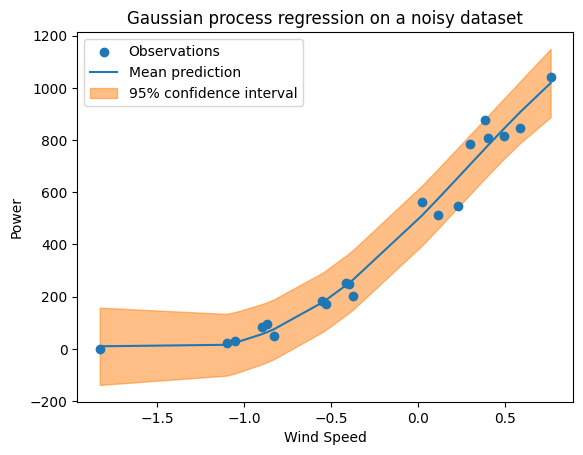

In [12]:
mean_prediction, std_prediction = gp_demo.predict(X, return_std=True)

plt.scatter(
    X,
    y,
    label="Observations",
    zorder=3
)

X_sorted, mean_prediction_sorted, std_prediction_sorted = zip(*sorted(zip(X, mean_prediction, std_prediction)))
X_sorted = np.array(X_sorted)
mean_prediction_sorted = np.array(mean_prediction_sorted)
std_prediction_sorted = np.array(std_prediction_sorted)

plt.plot(X_sorted,
         mean_prediction_sorted,
         label="Mean prediction",
         zorder=3
        )

plt.fill_between(
    X_sorted.ravel(),
    mean_prediction_sorted - 1.96 * std_prediction_sorted,
    mean_prediction_sorted + 1.96 * std_prediction_sorted,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
    zorder=1
)

plt.title("Gaussian process regression on a noisy dataset")
plt.xlabel("Wind Speed")
plt.ylabel("Power")
plt.legend()
plt.show()

In [13]:
y_train_pred = gp_demo.predict(X, return_std=False)
y_test_pred = gp_demo.predict(X_test_wind, return_std=False)

train_rmse = np.sqrt(mean_squared_error(y, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_mae = mean_absolute_error(y, y_train_pred)    
test_mae = mean_absolute_error(y_test, y_test_pred) 

print(f"Train RMSE: {train_rmse:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")
print(f"Train MAE: {train_mae:.3f}")
print(f"Test MAE: {test_mae:.3f}")

Train RMSE: 49.497
Test RMSE: 278.296
Train MAE: 37.575
Test MAE: 143.895


## GPs

In [12]:
"""
Take a random sample of 1000 datapoints. This because Gaussian Processes' training
require the inversion of the Kernel matrix, which is of size nxn for n data points.
This has complexity O(n^3), which is only feasible with a few thousands data points.
Because of the computational cost of GPs, we only consider 1,000 training data points.
Testing is computational inexpensive, so we use a larger dataset.
"""

num_train_points = 500
np.random.seed(42)
random_indices = np.random.choice(len(X_train_wind), num_train_points, replace=False)

X_train_sample = X_train[random_indices]
X_train_wind_sample = X_train_wind[random_indices]
y_train_sample = y_train[random_indices]

### GP using only wind speed (RBF + WhiteNoise Kernel)

In [13]:
# We select an RBF kernel with additional Gaussian measurement noise on the training observations given by a White kernel
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel()
gp_only_wind = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True, random_state=42, alpha=1e-4)
gp_only_wind.fit(X_train_wind_sample, y_train_sample)

print("After training the kernel hyperparameters are: ", gp_only_wind.kernel_)

In [16]:
y_train_pred, y_train_stddevs = gp_only_wind.predict(X_train_wind_sample, return_std=True)
y_test_pred, y_test_stddevs = gp_only_wind.predict(X_test_wind, return_std=True)

evaluate_and_save_metrics("GP (RBF, only-wind)", y_train_sample, y_test, y_train_pred, y_test_pred, ci=CONFIDENCE_INTERVAL)

Train RMSE: 51.797
Test RMSE: 348.140
Train MAE: 42.893
Test MAE: 179.282
Percentage of Test Data Points within 99.00% CI: -%
Percentage of Test Data Points within 99.00% CI: -%


/cs/student/projects1/2020/ffiocchi/ucl/fyp/fyp/utils.py:48: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([min_vals, max_vals], [min_vals, max_vals], 'k--', color='red')  # Add diagonal line


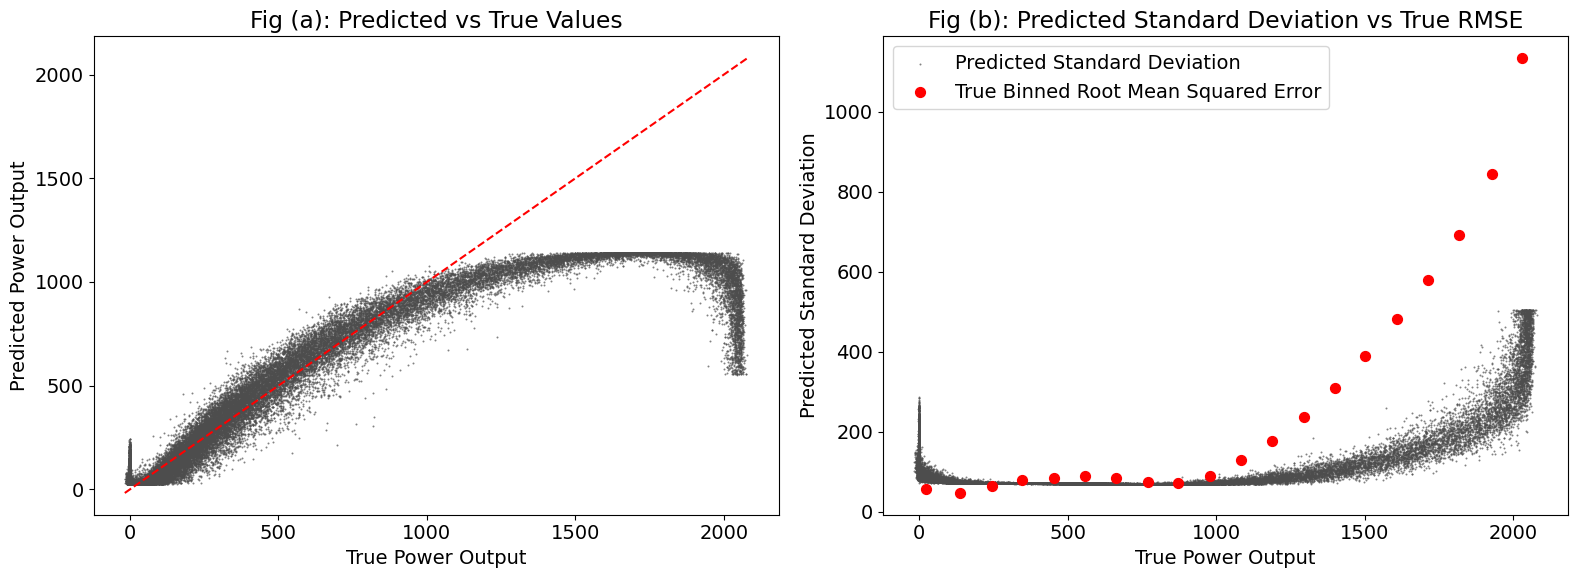

In [17]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs, save_path=f"figures/only_wind/preds.png")

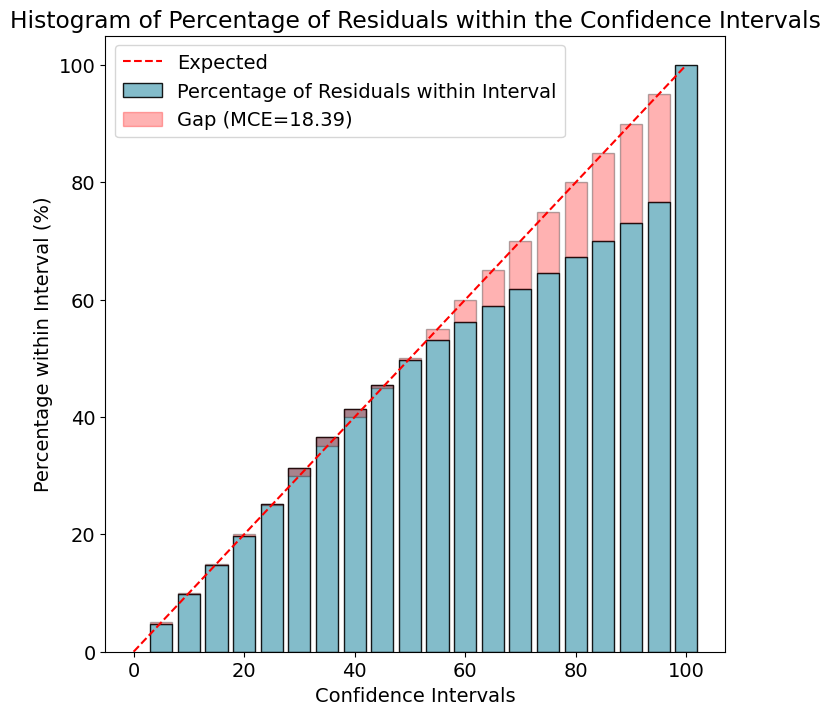

In [18]:
plot_confidence_interval_bar(y_test_pred, y_test_stddevs, y_test, bins=20, save_path=f"figures/only_wind/cis.png")

### GPs using all input features (comparison of different Kernels)

In [15]:
kernels = [
    RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)),
    Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)),
    RationalQuadratic(length_scale=1.0, alpha=1.0),
    DotProduct(sigma_0=1.0),
    ExpSineSquared(length_scale=1.0, periodicity=1.0),
]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Create and fit the GP model with each kernel
    for kernel in kernels:
        gp = GaussianProcessRegressor(kernel=kernel + WhiteKernel(), n_restarts_optimizer=9, normalize_y=True, random_state=42)
        gp.fit(X_train_sample, y_train_sample)

        print("Kernel: ", str(gp.kernel_))
        y_train_pred, y_train_stddevs = gp.predict(X_train_sample, return_std=True)
        y_test_pred, y_test_stddevs = gp.predict(X_test, return_std=True)

        file_suffix = str(gp.kernel_).split('(')[0]

        evaluate_and_save_metrics(file_suffix, y_train_sample, y_test, y_train_pred, y_test_pred, ci=CONFIDENCE_INTERVAL)
        plot_means_variances(y_test, y_test_pred, y_test_stddevs, save_path=f"figures/{file_suffix}/preds.png")
        plot_confidence_interval_bar(y_test_pred, y_test_stddevs, y_test, bins=20, save_path=f"figures/{file_suffix}/cis.png")
        print("\n")

### Autoencoder Feature Extractor + GP

We input the data into an Autoencoder to reduce dimensionality and extract feature. The purpose of the Autoencode is to reconstruct the original input while being forced into an encoding of 15 features and minimizing entropy. We extract a latent feature space to be used as the input to the subsequent GPs.

In [24]:
def autoencoder(encoding_dim):
    # Define the autoencoder model
    inputs = Input(shape=(len(FEATURES),))
    hidden = Dense(int(len(FEATURES)*0.7), activation='relu')(inputs)
    encoded = Dense(encoding_dim, activation='relu')(hidden)
    hidden = Dense(int(len(FEATURES)*0.7), activation='relu')(encoded)
    decoded = Dense(len(FEATURES), activation='linear')(encoded)
    
    
    autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)
    
    return autoencoder, encoder

encoding_dim = 15  # Define the dimensionality of the encoded representation
autoencoder, encoder = autoencoder(encoding_dim)

2024-03-21 15:26:30.902330: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-21 15:26:30.903479: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [26]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(X_train, X_train,
                epochs=50, batch_size=32,
                validation_split=0.1,
                callbacks=early_stopping
               )

Epoch 1/50
4262/4262 [==============================] - 2s 403us/step - loss: 0.0227 - val_loss: 0.0229
Epoch 2/50
4262/4262 [==============================] - 2s 400us/step - loss: 0.0227 - val_loss: 0.0229
Epoch 3/50
4262/4262 [==============================] - 2s 396us/step - loss: 0.0227 - val_loss: 0.0229
Epoch 4/50
4262/4262 [==============================] - 2s 403us/step - loss: 0.0227 - val_loss: 0.0231
Epoch 5/50
4262/4262 [==============================] - 2s 389us/step - loss: 0.0227 - val_loss: 0.0235
Epoch 6/50
4262/4262 [==============================] - 2s 400us/step - loss: 0.0227 - val_loss: 0.0228
Epoch 7/50
4262/4262 [==============================] - 2s 419us/step - loss: 0.0226 - val_loss: 0.0229
Epoch 8/50
4262/4262 [==============================] - 2s 405us/step - loss: 0.0226 - val_loss: 0.0229
Epoch 9/50
4262/4262 [==============================] - 2s 388us/step - loss: 0.0226 - val_loss: 0.0227
Epoch 10/50
4262/4262 [==============================] - 2s 399u

In [27]:
# Calculate the reconstruction error
X_train_decoded = autoencoder.predict(X_train)
X_test_decoded = autoencoder.predict(X_test)

mse_train = np.mean(np.square(X_train - X_train_decoded))
mse_test = np.mean(np.square(X_test - X_test_decoded))
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print("Train Reconstruction RMSE:", rmse_train)
print("Test Reconstruction RMSE:", rmse_test)

1184/1184 [==============================] - 0s 268us/step
Train Reconstruction RMSE: 0.14999927749741648
Test Reconstruction RMSE: 0.15062880293043915


In [28]:
norms = np.linalg.norm(X_test, axis=1)
mean_norm = np.mean(norms)
print("Normalized Reconstruction Test RMSE: ", rmse_test/mean_norm)

Normalized Reconstruction Test RMSE:  0.028282814237443984


In [30]:
# We encode the input data of train and test sets into the latent feature space
X_train_encoded_sample = encoder.predict(X_train_sample)
X_test_encoded = encoder.predict(X_test)

# Trained GP with RBF Kernel trained using the encoded data via the encoder obtained from the autoencoder
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel()
gp_autoencoder = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True, random_state=42)
gp_autoencoder.fit(X_train_encoded_sample, y_train_sample)

1184/1184 [==============================] - 0s 283us/step


/cs/student/projects1/2020/ffiocchi/ucl/fyp/fyp/.venvfyp/lib64/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/cs/student/projects1/2020/ffiocchi/ucl/fyp/fyp/.venvfyp/lib64/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=9, normalize_y=True,
                         random_state=42)

In [31]:
print("Kernel: ", str(gp_autoencoder.kernel_))
y_train_pred, y_train_stddevs = gp_autoencoder.predict(X_train_encoded_sample, return_std=True)
y_test_pred, y_test_stddevs = gp_autoencoder.predict(X_test_encoded, return_std=True)

evaluate_and_save_metrics("GP (RBF, autoencoder)", y_train_sample, y_test, y_train_pred, y_test_pred, ci=CONFIDENCE_INTERVAL)

Kernel:  RBF(length_scale=2.11) + WhiteKernel(noise_level=1e-05)
Train RMSE: 0.006
Test RMSE: 496.309
Train MAE: 0.005
Test MAE: 326.976
Percentage of Test Data Points within 99.00% CI: -%
Percentage of Test Data Points within 99.00% CI: -%


/cs/student/projects1/2020/ffiocchi/ucl/fyp/fyp/utils.py:48: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([min_vals, max_vals], [min_vals, max_vals], 'k--', color='red')  # Add diagonal line


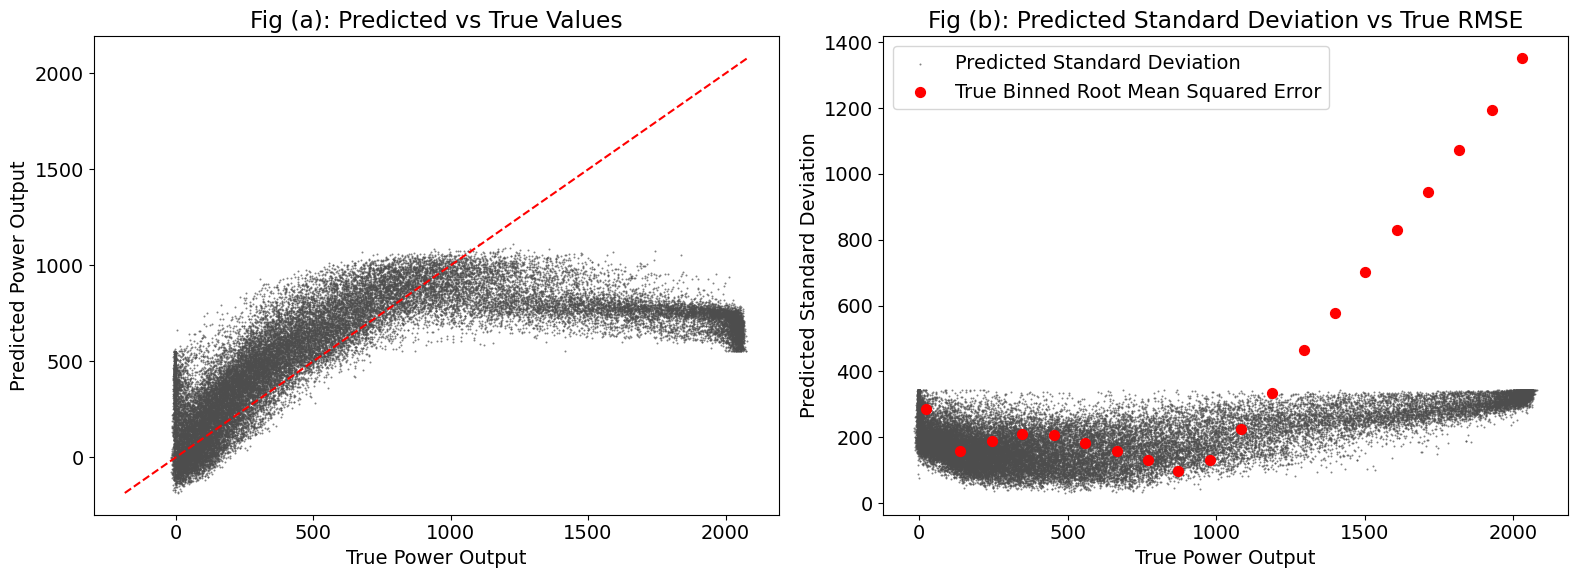

In [32]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs, save_path=f"figures/gp_autoencoder/preds.png")

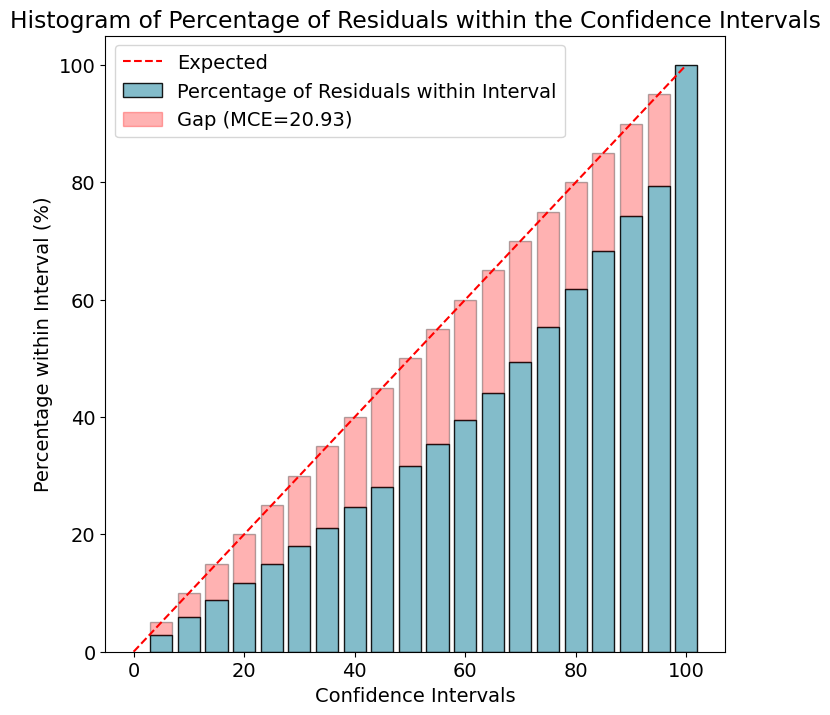

In [33]:
plot_confidence_interval_bar(y_test_pred, y_test_stddevs, y_test, bins=20, save_path=f"figures/gp_autoencoder/cis.png")

### GP with ARD Kernel

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Create the GaussianProcessRegressor with the ARD kernel
    np.random.seed(42)
    kernel = RBF(np.ones(X_train_sample.shape[1]), length_scale_bounds=(1e-2, 1e2)) + WhiteKernel()
    gp_ard = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True, random_state=42, alpha=1e-4)

    gp_ard.fit(X_train_sample, y_train_sample)
    print("After training the kernel hyperparameters are: ", gp_ard.kernel_)

In [36]:
y_train_pred, y_train_std = gp_ard.predict(X_train_sample, return_std=True)
y_test_pred, y_test_std = gp_ard.predict(X_test, return_std=True)

evaluate_and_save_metrics("GP (RBF, ARD)", y_train_sample, y_test, y_train_pred, y_test_pred, ci=CONFIDENCE_INTERVAL)

Train RMSE: 0.261
Test RMSE: 536.623
Train MAE: 0.199
Test MAE: 349.639
Percentage of Test Data Points within 99.00% CI: -%
Percentage of Test Data Points within 99.00% CI: -%


/cs/student/projects1/2020/ffiocchi/ucl/fyp/fyp/utils.py:48: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([min_vals, max_vals], [min_vals, max_vals], 'k--', color='red')  # Add diagonal line


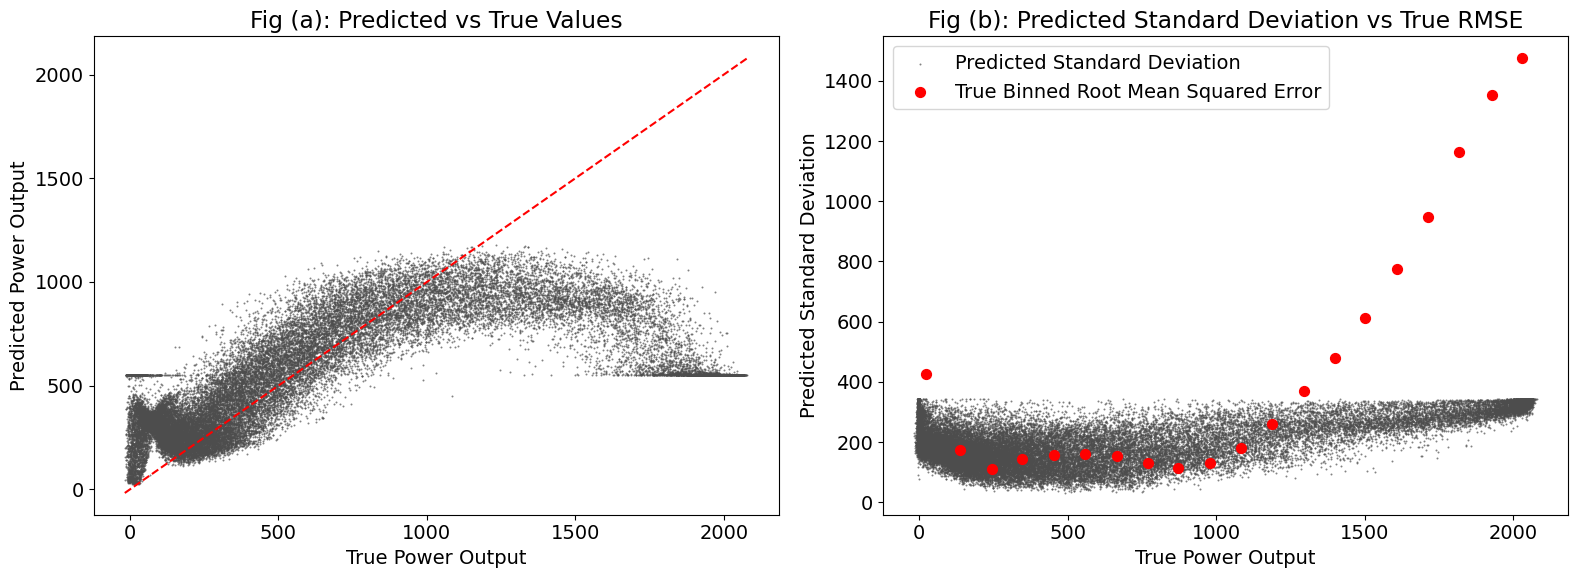

In [37]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs, save_path=f"figures/gp_ard/preds.png")

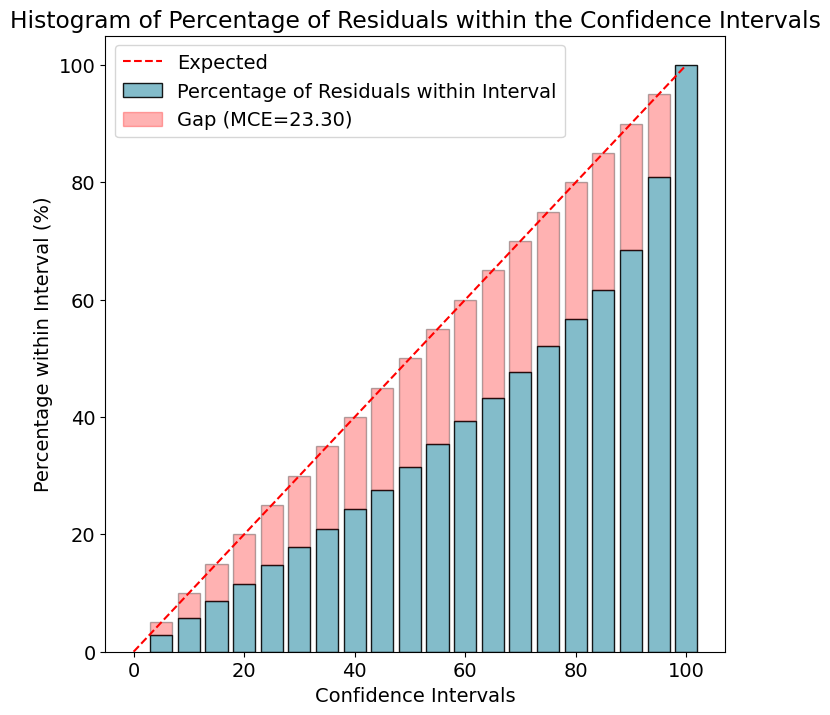

In [38]:
plot_confidence_interval_bar(y_test_pred, y_test_stddevs, y_test, bins=20, save_path=f"figures/gp_ard/cis.png")

### Sparse GP

We consider the entire data set, as we will be using inducing points approximation. Using the entire data set is necessary to compare this approach with other deep learning methodology where the entire data set is used. In this case 100 inducing points were used.

In [11]:
np.random.seed(42)
kernel = GPy.kern.RBF(input_dim=X_train.shape[1])
num_inducing = 100

# Considering 500 inducing points
gp_inducing = GPy.models.SparseGPRegression(X_train, np.array(y_train).reshape(-1, 1), kernel=kernel, num_inducing=num_inducing)
gp_inducing.optimize(messages=True)

In [12]:
y_train_pred, y_train_vars = gp_inducing.predict(X_train)
y_test_pred, y_test_vars = gp_inducing.predict(X_test)
y_train_pred = y_train_pred.squeeze()
y_test_pred = y_test_pred.squeeze()

if not isinstance(y_train, np.ndarray):
    y_train_full = y_train.to_numpy()
if not isinstance(y_test, np.ndarray):
    y_test_full = y_test.to_numpy()
    
y_train_pred = y_train_pred.squeeze()
y_test_pred = y_test_pred.squeeze()
y_train_stddevs = np.sqrt(y_train_vars.squeeze())
y_test_stddevs = np.sqrt(y_test_vars.squeeze())

name = "GP (RBF, sparse)"

save_preds(name, y_test_pred, y_test_stddevs)
evaluate_and_save_metrics(name, y_train, y_test, y_train_pred, y_test_pred, y_train_stddevs, y_test_stddevs, ci=CONFIDENCE_INTERVAL)

Train RMSE: 44.921
Test RMSE: 45.166
Train MAE: 30.482
Test MAE: 30.436
Percentage of Test Data Points within 99.00% CI: 97.37%
Percentage of Test Data Points within 99.00% CI: 97.32%
Percentage of Test Data Points within 99.00% CI: 94.22%
Percentage of Test Data Points within 99.00% CI: 94.31%


 /cs/student/projects1/2020/ffiocchi/ucl/fyp/fyp/utils.py:48: UserWarning:color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.


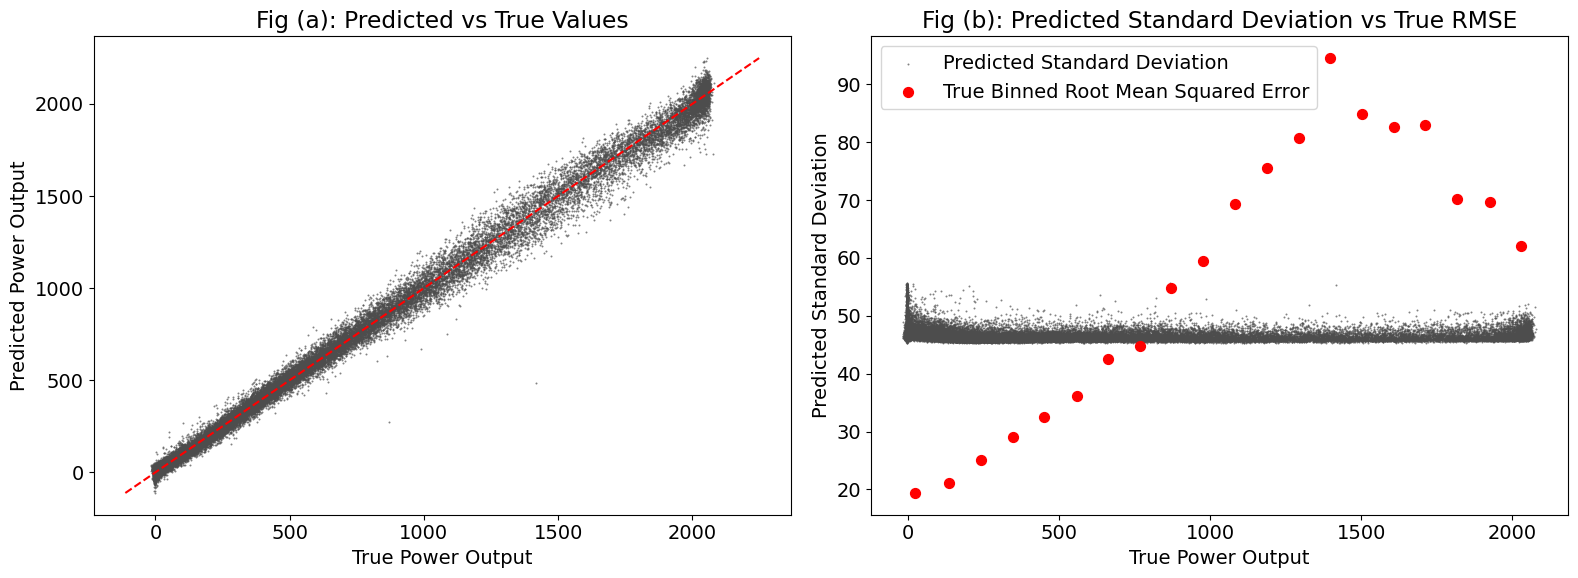

In [16]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)